In [2]:
# A) Kurulum + yardımcılar
%pip -q install scikit-learn==1.5.2 tqdm==4.66.4

import os, json, random, math, re, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import cv2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE:", DEVICE)

# Rastgelelik kontrolü
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

# Çeviri fonksiyonun zaten varsa onu kullan; yoksa min. fallback:
if 'translate_en_to_tr' not in globals():
    try:
        from deep_translator import GoogleTranslator
        def translate_en_to_tr(txt:str)->str:
            try:
                return GoogleTranslator(source='en', target='tr').translate(txt)
            except Exception:
                return txt
    except Exception:
        def translate_en_to_tr(txt:str)->str: return txt

# Basit overlay (model çıktısını görselleştirmek için)
def draw_overlay(img_rgb, en_text, tr_text, conf):
    img = img_rgb.copy()
    h, w = img.shape[:2]
    panel_w = min(int(0.9*w), 600)
    pad = 10
    lines = [f"{en_text}  ({conf*100:.1f}%)", f"{tr_text}"]
    font = cv2.FONT_HERSHEY_SIMPLEX; scale = 0.8; th = 2; line_h = 28
    panel_h = pad*2 + line_h*len(lines)
    overlay = img.copy()
    cv2.rectangle(overlay, (10,10), (10+panel_w, 10+panel_h), (0,0,0), -1)
    img = cv2.addWeighted(overlay, 0.55, img, 0.45, 0)
    y = 10 + pad + line_h
    cv2.putText(img, lines[0], (20,y), font, scale, (255,255,255), th, cv2.LINE_AA); y+=line_h
    cv2.putText(img, lines[1], (20,y), font, scale, (180,255,180), th, cv2.LINE_AA)
    return img


Note: you may need to restart the kernel to use updated packages.
DEVICE: cuda


In [4]:
# === [B] COCO -> sınıflandırma DataFrame (40 sınıflık hızlı versiyon) ===
import json
from pathlib import Path
import pandas as pd

ROOT = Path("/kaggle/input/2017-2017")
TRAIN_IM_DIR = ROOT/"train2017"/"train2017"
VAL_IM_DIR   = ROOT/"val2017"/"val2017"
ANN_DIR      = ROOT/"annotations_trainval2017"/"annotations"
TRAIN_JSON   = ANN_DIR/"instances_train2017.json"
VAL_JSON     = ANN_DIR/"instances_val2017.json"

def build_split_df(json_path:Path, img_dir:Path):
    with open(json_path, "r") as f:
        data = json.load(f)

    id2name = {cat["id"]:cat["name"] for cat in data["categories"]}
    imgs = {im["id"]: (img_dir/ im["file_name"]).as_posix() for im in data["images"]}

    rows = []
    for ann in data["annotations"]:
        if ann.get("iscrowd",0)==1: 
            continue
        img_id = ann["image_id"]
        cid = ann["category_id"]
        if img_id in imgs and cid in id2name:
            rows.append({
                "image": imgs[img_id],
                "class_id": cid,
                "class_name": id2name[cid]
            })

    df = pd.DataFrame(rows)
    # Görsel başına en sık görülen class seçelim
    df = (df.groupby("image")
            .agg(lambda x: x.value_counts().index[0])
            .reset_index())
    return df

df_tr = build_split_df(TRAIN_JSON, TRAIN_IM_DIR)
df_va = build_split_df(VAL_JSON,   VAL_IM_DIR)

print("Başlangıç Train:", df_tr.shape, " Val:", df_va.shape)

# --- sınıf sayısını kısıtlama (top 40) ---
KEEP_TOP_K = 40
top_cats = df_tr["class_name"].value_counts().head(KEEP_TOP_K).index.tolist()
df_tr = df_tr[df_tr["class_name"].isin(top_cats)].reset_index(drop=True)
df_va = df_va[df_va["class_name"].isin(top_cats)].reset_index(drop=True)

# --- sınıf başına örnek sayısını sınırla (hız için) ---
def stratified_cap(df, cap=200, seed=42):
    return (df.groupby("class_name", group_keys=False)
              .apply(lambda x: x.sample(min(len(x), cap), random_state=seed))
              .reset_index(drop=True))

CAP_PER_CLASS_TRAIN = 200
CAP_PER_CLASS_VAL   = 60

df_tr = stratified_cap(df_tr, cap=CAP_PER_CLASS_TRAIN)
df_va = stratified_cap(df_va, cap=CAP_PER_CLASS_VAL)

# --- id yeniden eşleme ---
classes = sorted(df_tr["class_name"].unique().tolist())
name2id = {n:i for i,n in enumerate(classes)}
id2name = {i:n for n,i in name2id.items()}
df_tr["label"] = df_tr["class_name"].map(name2id)
df_va["label"] = df_va["class_name"].map(name2id)

print("Son Train:", df_tr.shape, " Val:", df_va.shape)
print("Sınıf sayısı:", len(classes))
print(df_tr.head())


Başlangıç Train: (117266, 3)  Val: (4952, 3)
Son Train: (8000, 4)  Val: (2103, 4)
Sınıf sayısı: 40
                                               image  class_id class_name  \
0  /kaggle/input/2017-2017/train2017/train2017/00...         5   airplane   
1  /kaggle/input/2017-2017/train2017/train2017/00...         5   airplane   
2  /kaggle/input/2017-2017/train2017/train2017/00...         5   airplane   
3  /kaggle/input/2017-2017/train2017/train2017/00...         5   airplane   
4  /kaggle/input/2017-2017/train2017/train2017/00...         5   airplane   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


/tmp/ipykernel_565/1238665354.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), cap), random_state=seed))
/tmp/ipykernel_565/1238665354.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), cap), random_state=seed))


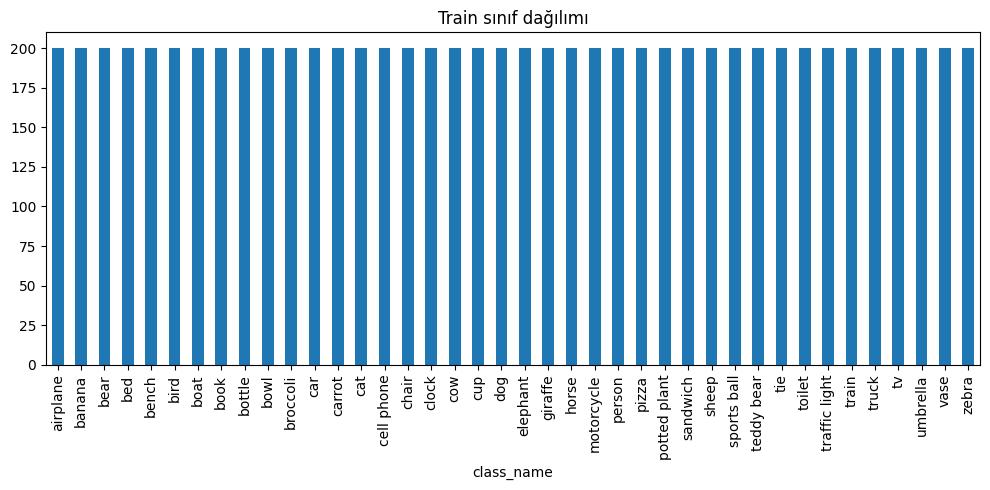

In [5]:
# C) Sınıf dağılımı çubuğu
cnt = df_tr["class_name"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,5))
cnt.plot(kind="bar")
plt.title("Train sınıf dağılımı")
plt.tight_layout(); plt.show()


In [6]:
# === [D] Dataset ve DataLoader (40 sınıf için optimize) ===
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

IM_SIZE = 224
# ImageNet ortalama ve std (sabit değerler)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IM_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IM_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

class CocoClsDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row.image)
        if img is None:
            raise FileNotFoundError(row.image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil = transforms.functional.to_pil_image(img)
        x = self.tfms(pil)
        y = int(row.label)
        return x, y, row.image  # path'i Grad-CAM için döndürüyoruz

# Daha hızlı eğitim için batch size küçültüldü
BATCH = 32
train_ds = CocoClsDataset(df_tr, train_tfms)
val_ds   = CocoClsDataset(df_va, val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Train set:", len(train_ds), " Validation set:", len(val_ds))


Train set: 8000  Validation set: 2103


100%|██████████| 66/66 [00:15<00:00,  4.39it/s]


[01] tr_acc=0.374 va_acc=0.413 | tr_loss=2.278 va_loss=2.207 | 93.8s


100%|██████████| 66/66 [00:13<00:00,  5.02it/s]


[02] tr_acc=0.501 va_acc=0.449 | tr_loss=1.752 va_loss=2.147 | 87.9s


100%|██████████| 66/66 [00:13<00:00,  4.89it/s]


[03] tr_acc=0.576 va_acc=0.496 | tr_loss=1.438 va_loss=1.840 | 87.6s


100%|██████████| 66/66 [00:13<00:00,  4.84it/s]


[04] tr_acc=0.657 va_acc=0.525 | tr_loss=1.152 va_loss=1.771 | 89.3s


100%|██████████| 66/66 [00:13<00:00,  4.94it/s]


[05] tr_acc=0.745 va_acc=0.566 | tr_loss=0.839 va_loss=1.657 | 90.0s


100%|██████████| 66/66 [00:13<00:00,  4.97it/s]


[06] tr_acc=0.838 va_acc=0.584 | tr_loss=0.532 va_loss=1.672 | 89.2s


100%|██████████| 66/66 [00:13<00:00,  5.01it/s]


[07] tr_acc=0.912 va_acc=0.597 | tr_loss=0.300 va_loss=1.759 | 87.5s


100%|██████████| 66/66 [00:13<00:00,  5.00it/s]


[08] tr_acc=0.948 va_acc=0.596 | tr_loss=0.193 va_loss=1.770 | 88.1s
Best val acc: 0.5972420353011976 -> best_resnet50_coco_cls.pth


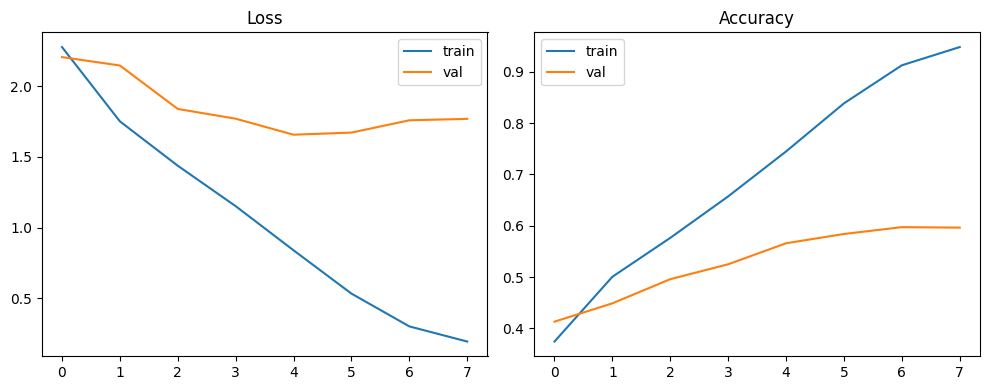

In [7]:
# E) Model ve eğitim
NUM_CLASSES = len(classes)
base_weights = ResNet50_Weights.IMAGENET1K_V2
clf_model = resnet50(weights=base_weights)
clf_model.fc = nn.Linear(clf_model.fc.in_features, NUM_CLASSES)
clf_model = clf_model.to(DEVICE)

LR = 1e-3
EPOCHS = 8
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(clf_model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds==y).float().mean().item()

def run_epoch(model, loader, train=True):
    model.train(train)
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    for x,y,_ in tqdm(loader, disable=False):
        x = x.to(DEVICE); y = y.to(DEVICE)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        acc = accuracy_from_logits(logits, y)
        bs = y.size(0)
        tot_loss += loss.item()*bs
        tot_acc  += acc*bs
        n += bs
    return tot_loss/n, tot_acc/n

history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
best_acc, best_path = -1, "best_resnet50_coco_cls.pth"

for ep in range(1, EPOCHS+1):
    t0=time.time()
    tr_loss, tr_acc = run_epoch(clf_model, train_loader, train=True)
    va_loss, va_acc = run_epoch(clf_model, val_loader, train=False)
    scheduler.step()
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    print(f"[{ep:02d}] tr_acc={tr_acc:.3f} va_acc={va_acc:.3f} | tr_loss={tr_loss:.3f} va_loss={va_loss:.3f} | {time.time()-t0:.1f}s")
    if va_acc>best_acc:
        best_acc=va_acc
        torch.save({"model":clf_model.state_dict(), "classes":classes}, best_path)
print("Best val acc:", best_acc, "->", best_path)

# Öğrenme eğrileri
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()


100%|██████████| 66/66 [00:13<00:00,  4.91it/s]


               precision    recall  f1-score   support

     airplane      0.900     0.763     0.826        59
       banana      0.750     0.623     0.680        53
         bear      0.720     0.857     0.783        42
          bed      0.519     0.741     0.611        54
        bench      0.386     0.500     0.436        44
         bird      0.492     0.500     0.496        60
         boat      0.720     0.720     0.720        50
         book      0.433     0.433     0.433        60
       bottle      0.385     0.250     0.303        60
         bowl      0.284     0.339     0.309        56
     broccoli      0.755     0.787     0.771        47
          car      0.325     0.217     0.260        60
       carrot      0.596     0.636     0.615        44
          cat      0.579     0.550     0.564        60
   cell phone      0.442     0.388     0.413        49
        chair      0.333     0.367     0.349        60
        clock      0.739     0.850     0.791        60
         

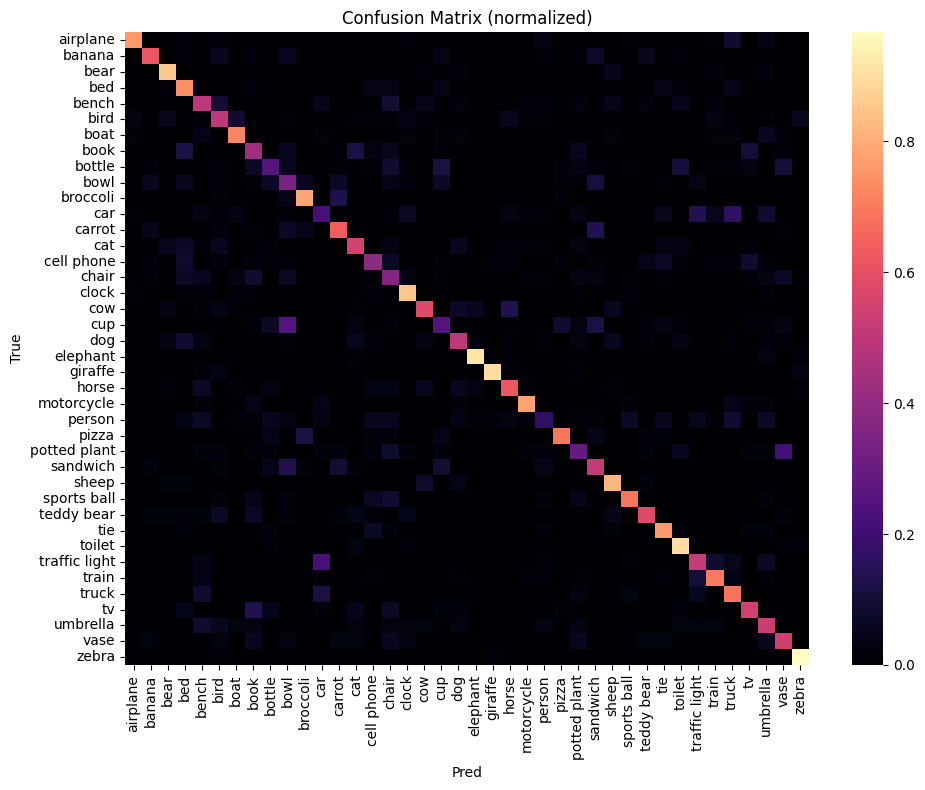

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# En iyi ağırlığı yükle
ckpt = torch.load("best_resnet50_coco_cls.pth", map_location=DEVICE)
clf_model.load_state_dict(ckpt["model"])

# Tüm val tahminleri
y_true, y_pred = [], []
clf_model.eval()
with torch.no_grad():
    for x,y,_ in tqdm(val_loader):
        x = x.to(DEVICE); y = y.to(DEVICE)
        logits = clf_model(x)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.cpu().tolist()); y_pred.extend(preds.cpu().tolist())

print(classification_report(y_true, y_pred, target_names=classes, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(10,8))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap="magma", cbar=True, xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (normalized)"); plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()


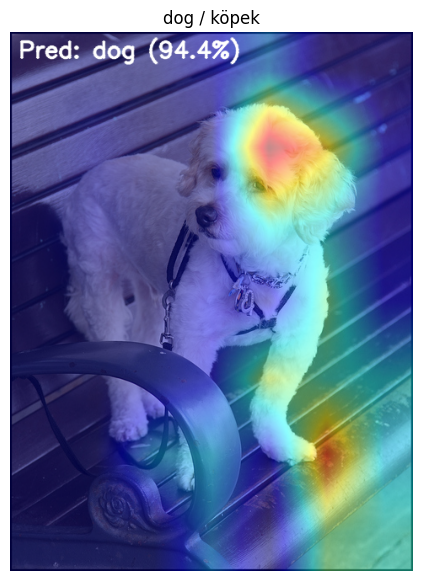

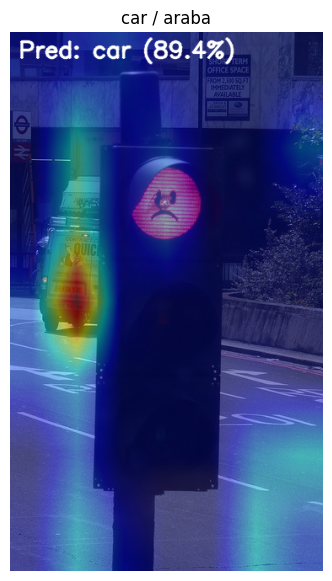

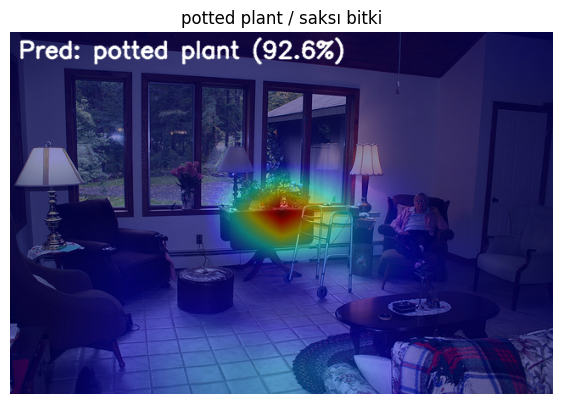

In [28]:
# G) Basit Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)
    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()
    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()
    def generate(self, class_idx):
        grads = self.gradients
        acts = self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)  # GAP
        cam = (weights*acts).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=(224,224), mode="bilinear", align_corners=False)
        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        return cam

# Hedef katman: resnet50.layer4[-1]
cam_engine = GradCAM(clf_model, clf_model.layer4[-1])

def show_gradcam_on_path(img_path, true_name=None, save_to=None):
    img_bgr = cv2.imread(img_path); img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = transforms.functional.to_pil_image(img_rgb)
    x = val_tfms(pil).unsqueeze(0).to(DEVICE)

    clf_model.eval()
    x.requires_grad_()
    logits = clf_model(x)
    prob = torch.softmax(logits, dim=1)[0]
    cls = int(prob.argmax())
    score = prob[cls]
    clf_model.zero_grad(set_to_none=True)
    score.backward()

    cam = cam_engine.generate(cls)
    heat = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    heat = cv2.resize(heat, (img_rgb.shape[1], img_rgb.shape[0]))
    blend = cv2.addWeighted(img_rgb, 0.55, heat, 0.45, 0)

    en = id2name[cls]
    tr = translate_en_to_tr(en)
    text = f"Pred: {en} ({score.item()*100:.1f}%)"
    cv2.putText(blend, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2, cv2.LINE_AA)
    if true_name:
        cv2.putText(blend, f"True: {true_name}", (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200,255,200), 2, cv2.LINE_AA)

    plt.figure(figsize=(7,7)); plt.imshow(blend); plt.axis("off"); plt.title(f"{en} / {tr}"); plt.show()
    if save_to: cv2.imwrite(save_to, cv2.cvtColor(blend, cv2.COLOR_RGB2BGR))

# Val setinden birkaç örnek göster
for p in df_va.sample(3, random_state=0)["image"].tolist():
    show_gradcam_on_path(p)


In [12]:
# === [Ön Hazırlık] deep-translator kurulumu ===
!pip install -q deep-translator==1.11.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00


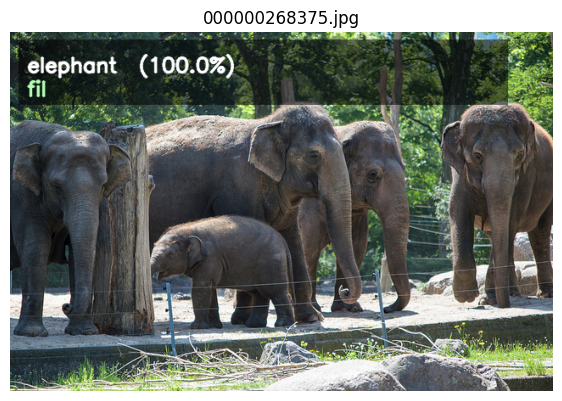

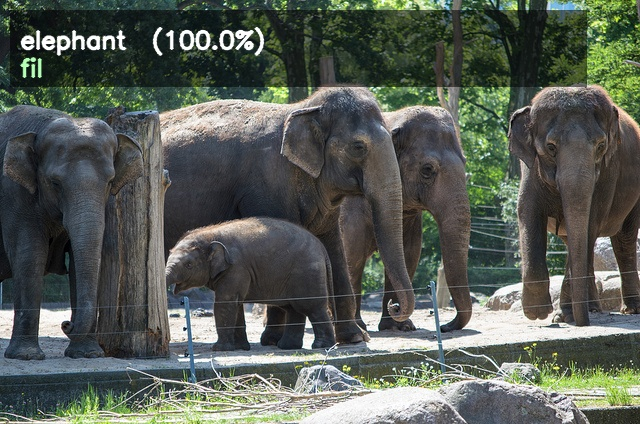

Görsel: /kaggle/input/2017-2017/val2017/val2017/000000268375.jpg
Top-1: elephant | TR: fil | 100.00%
Top-2: bear | TR: ayı | 0.00%
Top-3: person | TR: kişi | 0.00%
Top-4: bench | TR: tezgâh | 0.00%
Top-5: potted plant | TR: saksı bitki | 0.00%


In [26]:
# H) Eğitilen modelle top-k tahmin + overlay + EN->TR çeviri
from deep_translator import GoogleTranslator
from pathlib import Path
from IPython.display import display, Image as IPyImage

# --- EN->TR çeviri yardımcıları ---
_IMAGENET_TR = {
    "bald eagle": "kel kartal",
    "paddle": "kürek",
    "speedboat": "sürat teknesi",
    "canoe": "kano",
    "seashore": "deniz kıyısı",
    "laptop": "dizüstü bilgisayar",
    "cellular telephone": "cep telefonu",
    "tennis ball": "tenis topu",
    "soccer ball": "futbol topu",
}

_tr_cache = {}

def translate_en_to_tr(text: str) -> str:
    txt = (text or "").strip()
    if not txt:
        return txt
    # 1) sabit sözlük
    if txt in _IMAGENET_TR:
        return _IMAGENET_TR[txt]
    # 2) cache
    if txt in _tr_cache:
        return _tr_cache[txt]
    # 3) Google Translate
    try:
        tr = GoogleTranslator(source="en", target="tr").translate(txt)
        if tr:
            _tr_cache[txt] = tr
            return tr
    except Exception:
        pass
    return txt  # hata olursa İngilizceyi döndür

# --- prediction + görselleştirme ---
OUT_DIR = Path("./output_overlay_trained"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def predict_topk_trained(img_rgb, topk=5):
    pil = transforms.functional.to_pil_image(img_rgb)
    x = val_tfms(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = clf_model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    idxs = np.argsort(-probs)[:topk]
    items = []
    for i in idxs:
        en = id2name[i]
        tr = translate_en_to_tr(en)
        items.append((en, tr, float(probs[i])))
    return items

def run_one_random_show_save_val(seed=None, topk=5):
    if seed is not None: 
        random.seed(seed)
    row = df_va.sample(1).iloc[0]
    img_path = row.image
    bgr = cv2.imread(img_path); rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    items = predict_topk_trained(rgb, topk=topk)
    en, tr, conf = items[0]

    vis = draw_overlay(rgb, en, tr, conf)
    out_path = OUT_DIR/Path(img_path).name
    cv2.imwrite(str(out_path), cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(7,7)); plt.imshow(vis); plt.axis("off"); plt.title(Path(img_path).name); plt.show()
    display(IPyImage(filename=str(out_path)))

    print("Görsel:", img_path)
    for i,(e,t,c) in enumerate(items,1):
        print(f"Top-{i}: {e} | TR: {t} | {c*100:.2f}%")


_ = run_one_random_show_save_val(topk=5)
